## Introduction to Time Series Forecasting with Python
Jason Brownlee

https://machinelearningmastery.com/

<b>[1. Feature Engineering for Time Series](#1)<br></b>
    1.1 Lag Features<br>
    1.2 Rolling Window Statistics (check cookbook)<br>
    1.3 Expanding Window Statistics<br>
    
<b>[2. Plotting](#2)<br></b>
    2.1 Boxplots<br>
    2.2 Lag Scatter Plots<br>
    2.3 Autocorrelation plots (ACF)<br>
    2.4 Partial Autocorrelation plots (PACF)<br>
    2.5 Monthly & Quarterly plots<br>    
    
<b>[3. Resampling and Interpolation](#3)<br></b>
    3.1 Upsampling <br>
    3.2 Downsampling<br>
    
<b>[4. Power Transforms](#4)<br></b>
    4.1 Square Root Transform<br>
    4.2 Log Transform<br>
    4.3 Box-Cox Transform<br>
    
<b>[5. White Noise and Random Walk](#5)<br></b>
    5.1 White Noise<br>
    5.2 Random Walk<br>
    
<b>[6. Time Series Decomposition](#6)<br></b>
    6.1 Time Series Components<br>
    6.2 Combining Time Series Components<br>
    6.3 Time Series Decomposition: Hodrick Prescott Filter <br>
    6.4 Time Series Decomposition: ETS Decomposition <br>
    6.5 Time Series Decomposition: Other <br>
    6.6 Removing Trends<br>
    6.7 Removing Seasonality<br>
    
<b>[7. Stationary / Non-Stationary](#7)<br></b>
    7. 1 Stationary<br>
    7.2 Non-Stationary<br>
    7.3 Check for Stationarity<br>
    7.4 Statistical Tests: Augmented Dickery-Fuller (ADF)<br>
    
<b>[8. Model Evaluation](#8)<br></b>
    8.1 Multiple Train Test Splits<br>
    8.2 Walk Forward Validation (the k-folds validation of time series)<br>
    8.3 Explorining Residual Errors<br>
    
<b>[9. Forecasting Models](#9)<br></b>
    9.1 Box-Jenkins Method<br>
    9.2 Correcting Predictons with a Model of Residuals<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats

In [2]:
def parser(x):
    return datetime.strptime('190'+x,'%Y-%m')

temps = pd.read_csv('daily-min-temperatures.csv',parse_dates=True,index_col=0)
shampoo = pd.read_csv('shampoo.csv',index_col=0,date_parser=parser)
births = pd.read_csv('daily-total-female-births.csv',parse_dates=True,index_col=0)
passengers = pd.read_csv('airline-passengers.csv',parse_dates=True,index_col=0)

### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### <a id=1> 1. Feature Engineering for Time Series</a>

- Day, Month, Year, Minutes elapsed for the day, Hour of day, Business hours or not, Weekend or not, Season of the year, Business quarter of the year, Daylight savings or not, Public holiday or not, Leap year or not (check Cookbook)
- Lag features
- Rolling window statistics

#### 1.1 Lag Features
Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). 

The addition of lag features is called the <b>sliding window method</b>

A difficulty with the sliding window approach is determining the window width. It's good to perform a sensitivity analysis and try different window widths.

Additionally, why stop with a linear window? Perhaps you need a lag value from last week, last month, and last year. In the case of the temperature dataset, a lag value from the same day in the previous year or previous few years may be useful. 

In [11]:
#we discard the 1st row
temps1 = pd.concat([temps.shift(1),temps],axis=1)
temps1.columns = ['t','t+1']
temps1.head(3)

,t,t+1
Date,,
1981-01-01,NaN,20.7
1981-01-02,20.7,17.9
1981-01-03,17.9,18.8


In [12]:
#we can expand the window width and include more loagged features
#here we use the observations from t-2, t-1, t as features to predict the observation at t+1
temps2 = pd.concat([temps.shift(3),temps.shift(2),temps.shift(1),temps],axis=1)
temps2.columns = ['t-2','t-1','t','t+1']
temps2.head()

,t-2,t-1,t,t+1
Date,,,,
1981-01-01,NaN,NaN,NaN,20.7
1981-01-02,NaN,NaN,20.7,17.9
1981-01-03,NaN,20.7,17.9,18.8
1981-01-04,20.7,17.9,18.8,14.6
1981-01-05,17.9,18.8,14.6,15.8


#### 1.2 Rolling Window Statistics (check cookbook)
Using the summary of values at previous time steps as a feature.

A speacial case of rolling window statistics is the moving average.

The moving average can be used as a source of new information when modeling a time series forecast as a supervised learning problem. In this case, the moving average is calculated and added as a new input feature used to predict the next time step. 

First, a copy of the series must be shifted forward by one time step. This will represent the input to our prediction problem,
or a lag=1 version of the series (This is a standard supervised learning view of the time series problem).

Next, a second copy of the series needs to be shifted forward by one, minus the window size. This is to ensure that the moving average summarizes the last few values and does not include the value to be predicted in the average, which would be an invalid framing of the problem as the input would contain knowledge of the future being predicted.

<b> I feel like this is wrong, applying rolling(window) on a shift(1) is enough to have mean(t-2,t-1,t) as a feature and predict t+1. Here when using a shift(window-1) <=> shift(2) we end up with the mean(t-3,t-2,t-1)</b>

In [38]:
width = 3
lag1 = temps.shift(1)
lag3 = temps.shift(width-1)
temps3 = pd.concat([lag3.rolling(window=width).mean(), #moving average
                    lag3.rolling(window=width).max(),
                    lag3.rolling(window=width).min(),
                    lag1,
                    temps],axis=1)
temps3.columns = ['mean(t-3,t-2,t-1)','max(t-3,t-2,t-1)','min(t-3,t-2,t-1)','t','t+1']
temps3.head(6)

,"mean(t-3,t-2,t-1)","max(t-3,t-2,t-1)","min(t-3,t-2,t-1)",t,t+1
Date,,,,,
1981-01-01,NaN,NaN,NaN,NaN,20.7
1981-01-02,NaN,NaN,NaN,20.7,17.9
1981-01-03,NaN,NaN,NaN,17.9,18.8
1981-01-04,NaN,NaN,NaN,18.8,14.6
1981-01-05,19.133333,20.7,17.9,14.6,15.8
1981-01-06,17.100000,18.8,14.6,15.8,15.8


#### 1.3 Expanding Window Statistics
- Helps keep track of the bounds of observal data 
- For each timestep expand() is set of value of all prior timesteps

In [25]:
temps4 = pd.concat([temps.shift(1).expanding().mean(),
                    temps.shift(1).expanding().max(),
                    temps.shift(1).expanding().min(),
                    temps],axis=1)
temps4.columns = ['mean(t-1,t)','max(t-1,t)','min(t-1,t)','t']
temps4.head()

,"mean(t-1,t)","max(t-1,t)","min(t-1,t)",t
Date,,,,
1981-01-01,NaN,NaN,NaN,20.7
1981-01-02,20.700000,20.7,20.7,17.9
1981-01-03,19.300000,20.7,17.9,18.8
1981-01-04,19.133333,20.7,17.9,14.6
1981-01-05,18.000000,20.7,14.6,15.8


### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### <a id =2> 2. Plotting</a>

- Boxplots
- Heatmaps
- Lag scatter plots
- Autocorrelation plots
- Partial Autocorrelation plots

#### 2.1 Boxplots

Check more time frequencies to use for pd.Grouper<br>
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [96]:
# 1/ Boxplot for temps by Year
#turn the 1 column dataframe into a series for Grouper to work
temps_series = temps.squeeze()
groups = temps_series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values

years.head(2)

,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
0,20.7,17.0,18.4,19.5,13.3,12.9,12.3,15.3,14.3,14.8
1,17.9,15.0,15.0,17.1,15.2,13.8,13.8,14.3,17.4,13.3


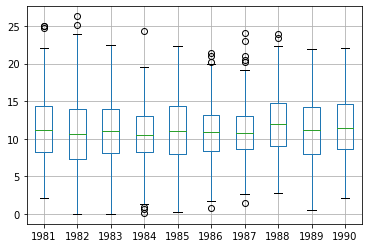

In [69]:
years.boxplot();

In [99]:
#2/ Boxplot for temps by Month for 1 Year
groups = temps_series['1990'].groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(c[1].values) for c in groups],axis=1)
months.columns = range(1,13)

months.head(2)

,1,2,3,4,5,6,7,8,9,10,11,12
0,14.8,12.0,19.3,15.3,13.0,9.7,7.4,6.8,6.0,11.3,15.4,13.3
1,13.3,12.2,17.3,14.7,13.9,8.2,7.3,9.8,9.5,10.5,11.8,13.2


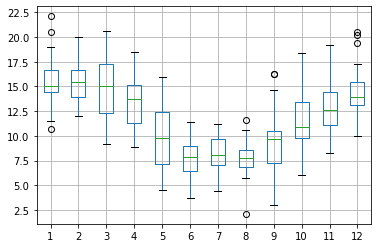

In [101]:
months.boxplot();

#### 2.2 Lag Scatter Plots

- Time series modeling assumes a relationship between an observation and the previous observation. 
- Previous observations in a time series are called lags, with the observation at the previous step called lag1, the observation at two time steps ago lag=2,...
- Laplot shows the observation at time t on the x-axis and the observation at the next time step (t+1) on the y-axis.
- More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.

In [102]:
from pandas.plotting import lag_plot

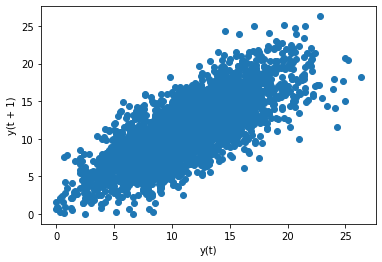

In [104]:
lag_plot(temps);

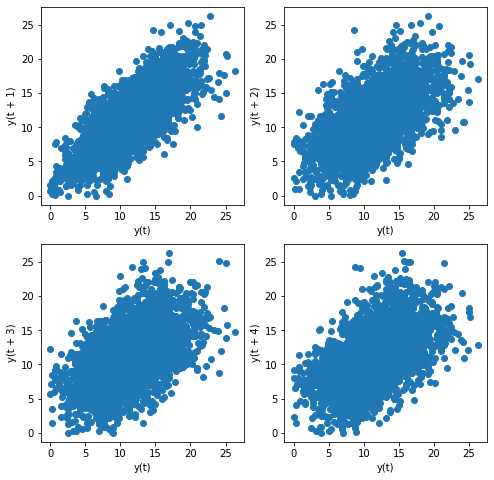

In [127]:
#Create a lag plot for 7 days lags
fig, ax = plt.subplots(2,2,figsize=(8,8))
lag_plot(temps,lag=1,ax=ax[0,0])
lag_plot(temps,lag=2,ax=ax[0,1])
lag_plot(temps,lag=3,ax=ax[1,0])
lag_plot(temps,lag=4,ax=ax[1,1]);

#### 2.3 Autocorrelation plots (ACF)
Quantify the strength and type of relationship between observations and their lags.

The resulting plot shows lag along the x-axis and the correlation on the y-axis. Dotted lines are provided that indicate any correlation values above those lines are statistically significant. We can see that for the Minimum Daily Temperatures dataset we see cycles of strong negative and positive correlation. This captures the relationship of an observation with past observations in the same and opposite seasons or times of year. Sine waves like those seen in this example are a strong sign of seasonality in the dataset.

A sharp dropoff would mean that there is no AR component in the ARIMA model.

In [5]:
# Method1
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

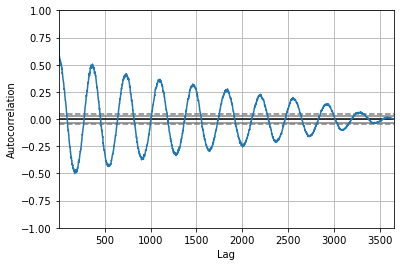

In [133]:
autocorrelation_plot(temps);

In [6]:
# Method2
from statsmodels.graphics.tsaplots import plot_acf

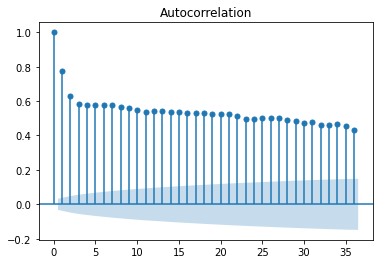

In [16]:
#no sharp drop off so we have an AR component in the ARIMA model
#the shady region is a 95% confidence interval. correlations outside the region are very likely to be real correlations
plot_acf(temps); #lags=

#### 2.4 Partial Autocorrelation Plots (PACF)
Describes the direct relationship between an observation and its lag (uses residuals). 

Works best with stationary data.

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf

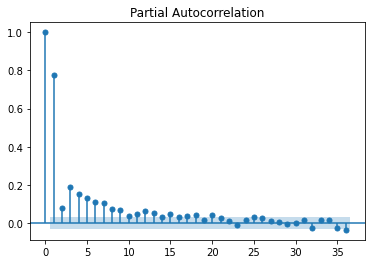

In [15]:
plot_pacf(temps);

#### 2.5 Monthly & Quarterly plots

In [35]:
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import quarter_plot

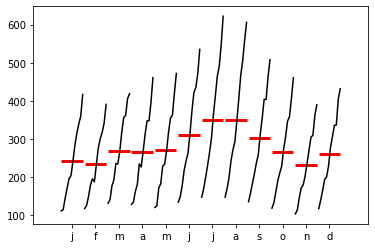

In [36]:
month_plot(passengers); #df.index.freq needs to be monthly

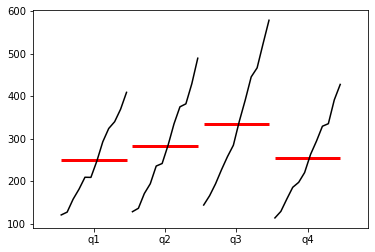

In [33]:
quarter_plot(passengers.resample(rule='Q').mean()); #df.index.freq needs to be quarterly

### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### <a id=3> 3. Resampling and Interpolation</a>

There are 2 main purposes of resampling:

- Problem Framing: Resampling may be required if the data is not available at the same frequency that we want to make predictions.
- Feature Engineering: Resampling can be used to provide additional structure or insight into the learning problem for supervised learning models.

#### 3.1 Upsampling 

Where you increase the frequency of the samples, such as from minutes to seconds.

In [2]:
shampoo.head(3)

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1


In [189]:
#Upsample it to a daily time series
shampoo_daily = shampoo.resample('D').mean()
shampoo_daily.head(3)

,Sales
Month,
1901-01-01,266.0
1901-01-02,NaN
1901-01-03,NaN


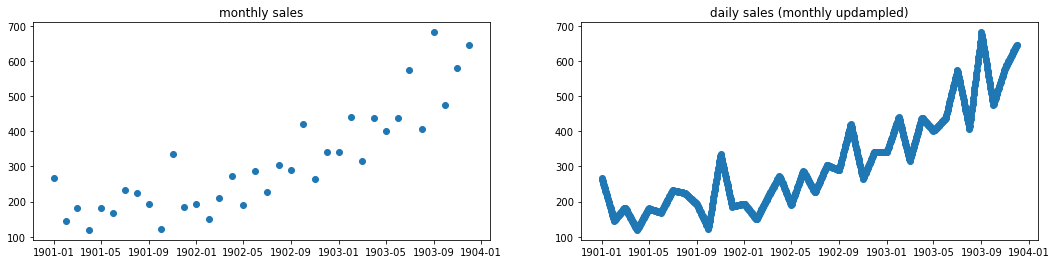

In [190]:
#Interpolate the missing data
shampoo_daily = shampoo_daily.interpolate(method='linear')

fig, ax = plt.subplots(1,2,figsize=(18,4))
ax[0].scatter(shampoo.index,shampoo['Sales'])
ax[0].set_title('monthly sales');
ax[1].scatter(shampoo_daily.index,shampoo_daily['Sales'])
ax[1].set_title('daily sales (monthly updampled)');

#### 3.2 Downsampling 

Where you decrease the frequency of the samples, such as from days to months.

In [192]:
#Downsampling to quarterly intervals
shampoo_quarterly = shampoo.resample('Q').mean()
shampoo_quarterly.head(3)

,Sales
Month,
1901-03-31,198.333333
1901-06-30,156.033333
1901-09-30,216.366667


### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### <a id=4>  4. Power Transforms</a>
- Square root transform
- Log transform
- Box-Cox transform


#### 4.1 Square Root Transform
Used to make a times series that has a quadratic growth trend linear

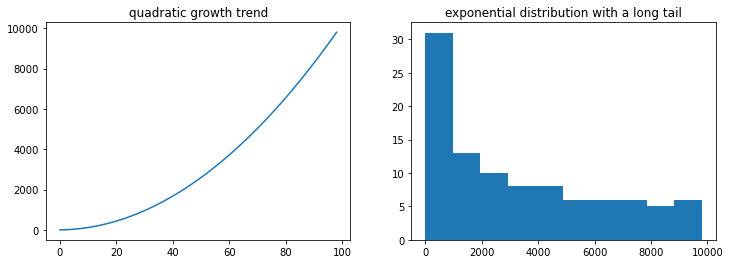

In [197]:
quadratic_series = [i**2 for i in range(1,100)]

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(quadratic_series)
ax[0].set_title('quadratic growth trend')
ax[1].hist(quadratic_series)
ax[1].set_title('exponential distribution with a long tail');

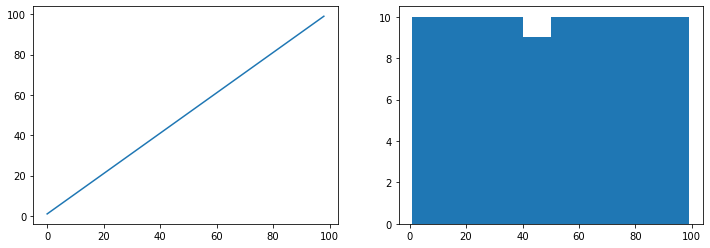

In [200]:
#here the quadratic trend is made linear
transform = np.sqrt(quadratic_series)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(transform)
ax[1].hist(transform);

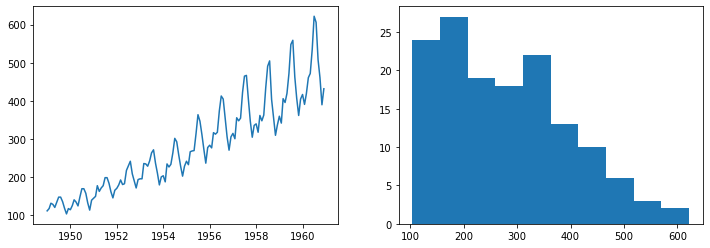

In [201]:
#we repeat the same thing for the passengers dataset
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(passengers)
ax[1].hist(passengers);

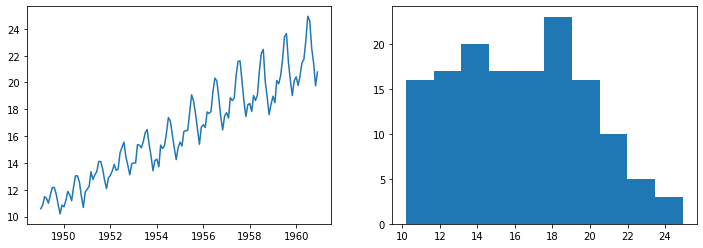

In [202]:
root_transform = np.sqrt(passengers)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(root_transform)
ax[1].hist(root_transform);

#### 4.2 Log Transform
- Deals with more extreme trends: exponential, and makes them linear
- Assumes values are positive (if not we can add a constant to all variables)

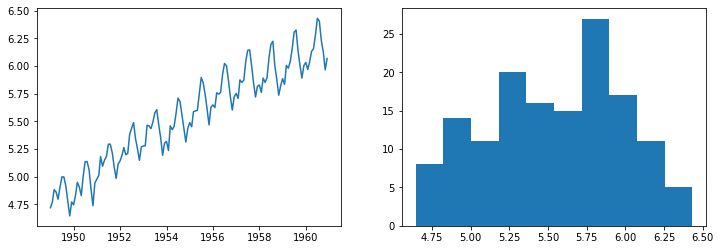

In [203]:
#here we get a trend that is a lot more linear than the square root transform
log_transform = np.log(passengers)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(log_transform)
ax[1].hist(log_transform);

#### 4.3 Box-Cox Transform

The square root transform and log transform belong to a class of transforms called power transforms. The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

More than that, it can be configured to evaluate a suite of transforms automatically and select a best fit. 

- lambda = -1.0 reciprocal transform.
- lambda = -0.5 reciprocal square root transform.
- lambda = 0.0 log transform.
- lambda = 0.5 square root transform.
- lambda = 1.0 no transform

In [204]:
from scipy.stats import boxcox

lambda:  0.14802265137037945


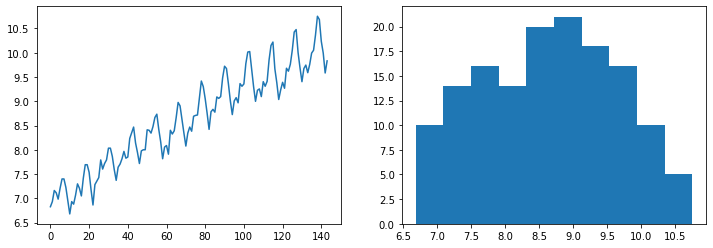

In [216]:
#lambda= None lets the function find a statistically tuned value. 
#the resulting transform is very close to a log transform (0) and less than a square root transform (0.5)
log_transform = boxcox(passengers.squeeze(), lmbda=None)

fig, ax = plt.subplots(1,2,figsize=(12,4))
print('lambda: ',log_transform[1])
ax[0].plot(log_transform[0])
ax[1].hist(log_transform[0]);

### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷

###  <a id=5> 5. White Noise and Random Walk </a>

#### 5.1 White Noise

A time series may be white noise. A time series is white noise if the variables are independent and identically distributed with a mean of zero. This means that all variables have the same variance (sigma2) and each value has a zero correlation with all other values in the series.

Why Does it Matter?

- Predictability: If a time series is white noise, then, by definition, it is random. we cannot reasonably model it and make predictions.
- Model Diagnostics: The series of errors from a time series forecast model should ideally be white noise. Otherwise the model needs improvements.

#### Is my time series white noise?

A time series is not white noise if any of the following conditions are true:
- the series has a non-zero mean.
- the variance changes over time.
- values correlate with lag values.

Tools for checking: 
- Create a line plot. Check for gross features like a changing mean, variance, or obvious relationship between lagged variables.
- Calculate summary statistics. Check the mean and variance of the whole series against the mean and variance of meaningful contiguous blocks of values in the series (e.g. days, months, or years).
- Create an autocorrelation plot. Check for gross correlation between lagged variables

In [60]:
from random import gauss

In [65]:
#Example of a white noise series
random_s = pd.Series([gauss(0,1) for i in range(1000)])

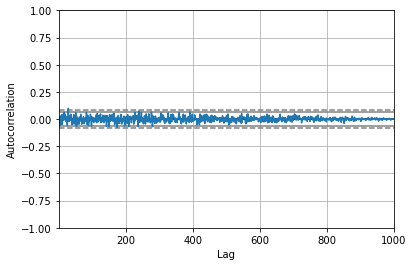

In [67]:
#correlation with lags is below the significance line
autocorrelation_plot(random_s);

#### 5.2 Random Walk

A random walk is different from a list of random numbers because the next value in the sequence is a modification of the previous value in the sequence. This dependence provides some consistency from step-to-step rather than the large jumps that a series of independent, random numbers provides. 

A simple model of a random walk is as follows:

1. Start with a random number of either -1 or 1.
2. Randomly select a -1 or 1 and add it to the observation from the previous time step
3. Repeat step 2 for as long as you like.

<b>When is my time series a random walk?</b>

- The time series shows a strong temporal dependence that decays linearly or in a similar pattern.
- The time series is non-stationary and making it stationary shows no obviously learnables tructure in the data.
- The persistence model provides the best source of reliable predictions.

The random walk hypothesis is a theory that stock market prices are a random walk and cannot be predicted.

In [68]:
from random import random

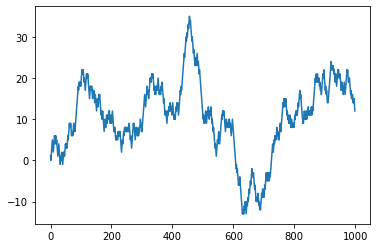

In [74]:
#generate a random walk series
random_walk = [-1 if random() < 0.5 else 1] #start with 1 or -1
for i in range(1,1000):
    movement = -1 if random() < 0.5 else 1
    random_walk.append(random_walk[i-1] + movement)

plt.plot(random_walk);

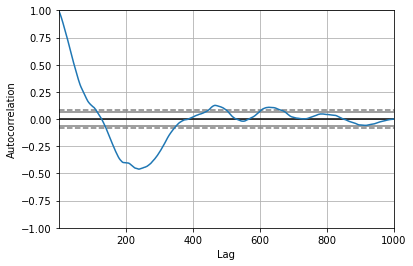

In [76]:
#Random walk and autocorrelation
#random walks are non-stationary, the current obs is a random step from the previous obs. They depend on time
autocorrelation_plot(random_walk);

### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### <a id=6> 6. Time Series Decomposition</a>

#### 6.1 Time Series Components

- Level: The baseline value for the series if it were a straight line.
- Trend: The optional and often linear increasing or decreasing behavior of the series over time.
- Seasonality: The optional repeating patterns or cycles of behavior over time.<br>
/Cyclicity: When the cycles don't have set frequency (constantly changing
- Noise: The optional variability in the observations that cannot be explained by the model.

All time series have a level, most have noise, and the trend and seasonality are optional

Components of the time series that have consistency or recurrence and can be described and modeled are called Systematic Components: Level, Trend, Seasonality.

Components of the time series that cannot be directly modeled are called Non-Systematic Components: Noise.

#### 6.2 Combining Time Series Components

- <u>Additive model:</u> it's linear. A linear trend is a straight line. A linear seasonality has the same frequency and amplitude over time.
        y(t) = level + trend + seasonality + noise

- <u>Multiplicative model:</u> it's non-linear (ex: quadratic, exponential). A non-linear trend is a curved line. A no-linear has an increasing/decreasing frequency and/or amplitude over time.
        y(t) = level x trend x seasonality x noise

#### 6.3 Time Series Decomposition: Hodrick Prescott Filter

Separates the time series into a trend component and a cyclical component.

        Y(t) = T(t) + C(t)

lambda: handles the variations in the growth rate of the trend component
- quarterly data: lambda = 1600
- annual data: lamnda = 6.25
- monthly data: lamnda = 129,600

In [1]:
from statsmodels.tsa.filters.hp_filter import hpfilter

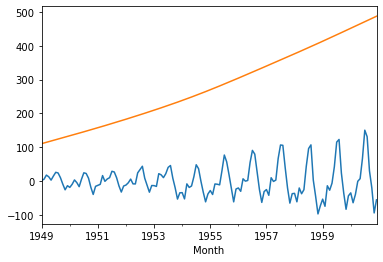

In [7]:
cycle , trend = hpfilter(passengers,lamb=129600)

cycle.plot()
trend.plot();

#### 6.4 Time Series Decomposition: ETS Decomposition 

Error/Trend/Seasonality Decomposition. Naive, classical, needs specifiying whether the model is additive or multiplicative. Results should be interpreted carefully.
             
                 Y(t) = E(t) + T(t) + S(t)

In [4]:
#1/ Automatic Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

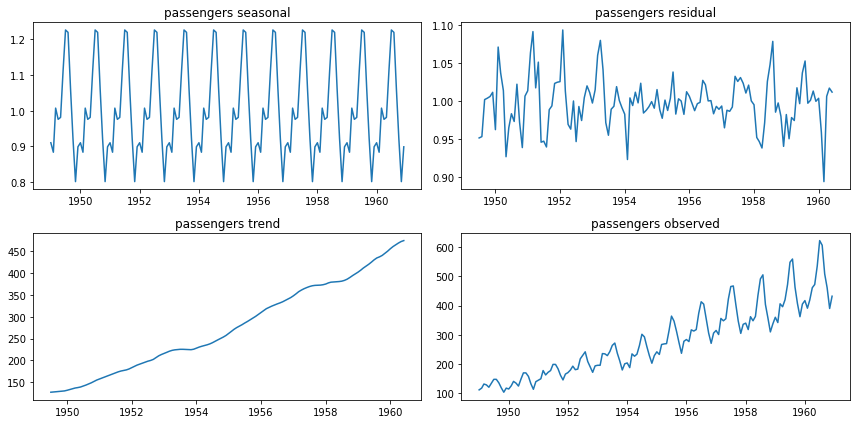

In [7]:
passengers_decomp = seasonal_decompose(passengers,model='multiplicative')

fig, ax = plt.subplots(2,2,figsize=(12,6))

ax[0,0].plot(passengers_decomp.seasonal)
ax[0,0].set_title('passengers seasonal')

ax[0,1].plot(passengers_decomp.resid)
ax[0,1].set_title('passengers residual')

ax[1,0].plot(passengers_decomp.trend)
ax[1,0].set_title('passengers trend')

ax[1,1].plot(passengers_decomp.observed)
ax[1,1].set_title('passengers observed')
plt.tight_layout();

#### 6.5 Time Series Decomposition: Other
- Season-Trend decomposition using LOESS: statsmodels.tsa.seasonal.STL (Advanced)
- Baxter-King filter: statsmodels.tsa.filters.bk_filter.bkfilter
- Christiano-Fitzgerald asymmetric, random walk filter: statsmodels.tsa.filters.cf_filter.cffilter
- Linear filtering via convolution: statsmodels.tsa.filters.convolution_filter

#### 6.6 Removing Trends

<u>Purpose of finding trends:</u>

- Remove Information: To remove systematic information that distorts the relationship between input and output variables.
- Add Information: To add systematic information to improve the relationship between input and output variables.

<u>Types of trends:</u>

- Deterministic Trends: trends that consistently increase or decrease.
- Stochastic Trends: trends that increase and decrease inconsistently.

- Global Trends: trends that apply to the whole time series.
- Local Trends: trends that apply to parts or subsequences of a time series.

<u>Detrend by Differencing</u>

    value(t) = obs(t) - obs(t-1)  has the effect of removing a trend

This approach works well for linear trends. If the trend is quadratic we'll need data.diff().diff()... as necessary.

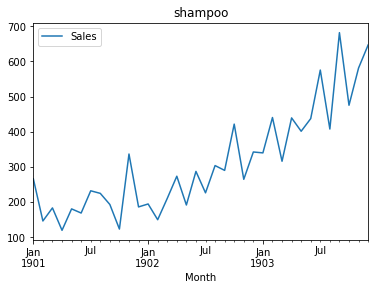

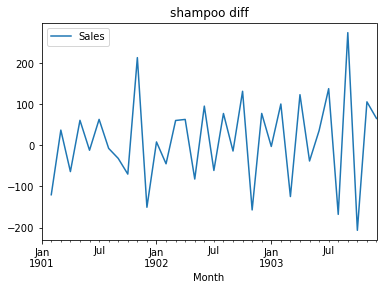

In [8]:
shampoo.plot(title='shampoo')
shampoo.diff().plot(title='shampoo diff');

<u> Detrend by Model Fitting</u>

The predictions a linear model (linear trends) or polynomial model (non-linear trends) will form a straight line that can be taken as the trend line for the dataset. These predictions can also be subtracted from the original time series to provide a detrended version of the dataset.

        value(t) = obs(t) - prediction(t)

In [98]:
from sklearn.linear_model import LinearRegression

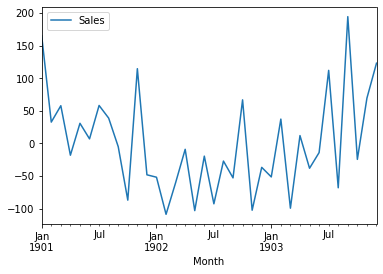

In [24]:
X = np.arange(len(shampoo)).reshape(-1,1)
y = shampoo.values.reshape(-1,1)

model = LinearRegression()
model.fit(X,y)

trend = model.predict(X)

detrended = shampoo - trend
detrended.plot();

#### 6.7 Removing Seasonality

Seasonality (repeating cycle) may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models.

Understanding seasonality can improve our model in 2 ways:

- Clearer Signal: Identifying and removing the seasonal component from the time series can result in a clearer relationship between input and output variables (Data cleaning).
- More Information: Additional information about the seasonal component of the time series can provide new information to improve model performance (Feature engineering).

<u> Seasonal adjustment with differencing</u>

If there is a seasonal component at the level of one week, then we can remove it on an observation today by subtracting the value from last week....same applies to all kinds of frequencies.

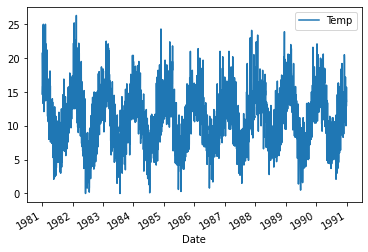

In [28]:
#here we have a seasonal component each year showing a swing from summer to winter
# we can correct that with value(t) = obs(t) - obs(t-1year)
temps.plot();

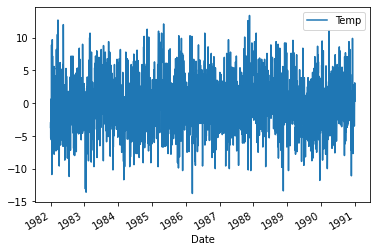

In [75]:
#!!!!!This does not consider that there are 2 leap years in our data, the offsets are wrong by 2 days
temps.diff(365).plot();

Improved option: Instead of substracting the temp from the same day in the previous year, we substract the average temp on that month from the previous year.

                 value(t) = obs(t) - monthly_mean(t-1year)
                 
This is robust to daily fluctualtions and is not affected by leap years

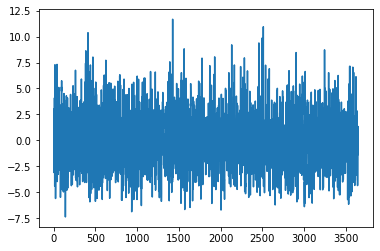

In [83]:
monthly_mean = temps.resample('M').mean()
monthly_mean.set_index(monthly_mean.index.to_period('M'))

temps['month_year'] = temps.index.to_period('M')
adjusted = []

for index, row in temps.iterrows():
    adjusted.append(float(temps.loc[index,'Temp'] - monthly_mean.loc[str(row[1])].values.flatten()))

plt.plot(adjusted);

<u> Seasonal adjustment with modeling</u>

We can model the seasonal component directly, then subtract it from the observations. The seasonal component in a given time series is likely a sine wave over a generally fixed period and amplitude. This can be approximated easily using a curve-fitting method. 

Limitation: does not take into account leap years which creates some noise. We can adjust & remove the Feb 29 observations

In [97]:
from sklearn.preprocessing import PolynomialFeatures

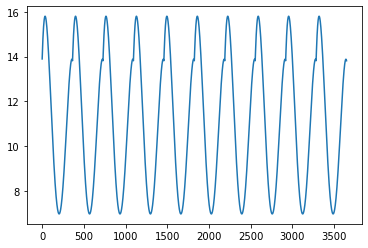

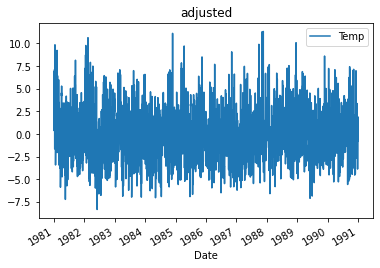

In [113]:
#METHOD1: sklearn
X = np.array([i%365 for i in range(len(temps))]).reshape(-1,1)
y = temps.values.reshape(-1,1)

linear = LinearRegression()
poly = PolynomialFeatures(4)

X_poly = poly.fit_transform(X)
linear.fit(X_poly,y)

seasonal = linear.predict(X_poly)

adjusted = temps - seasonal
plt.plot(seasonal)
adjusted.plot(title='adjusted');

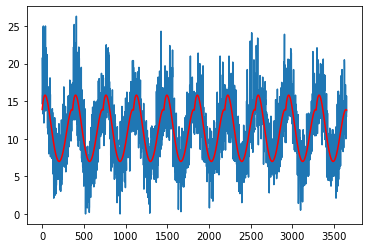

In [143]:
#METHOD2: python: result is the same as above
X = [i%365 for i in range(len(temps))]
y = temps.values

#get polynomial coefficients
degree = 4
coef = np.polyfit(X,y,degree)

#create a curve
seasonal2 = np.repeat(float(coef[-1]),len(X))
for i in range(len(X)):
    for d in range(degree):
        seasonal2[i] += X[i]**(degree-d) * coef[d]

plt.plot(temps.values)
plt.plot(seasonal2,color='r')

### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### <a id=7> 7. Stationary / Non-Stationary </a>

#### 7. 1 Stationary 
- No trend or seasonal effects
- Summary statistics (mean, std) calculated on the time series are consistent over time
- Easier to model. Statistical models require the time series to be stationary.

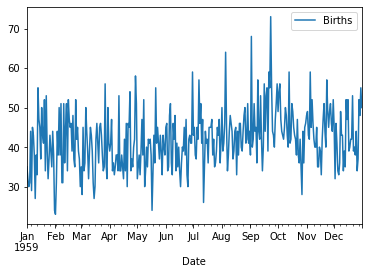

In [80]:
births.plot();

#### 7.2 Non-Stationary
- Seasonal effects that depend on time
- Summary statistics change over time
- Classical statistical models (ARIMA) are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects. But machine learning models try to add the non-stationary trait as a source of information that is used in feature engineering.

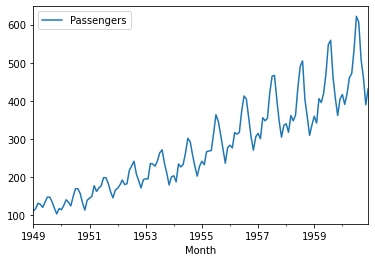

In [79]:
passengers.plot();

#### 7.3 Check for Stationarity
- Plots
- Summary statistics of random partitions
- Statistical tests

In the passengers dataset we can see an obvious seasonal component which looks like it's growing exponentially from season to season.

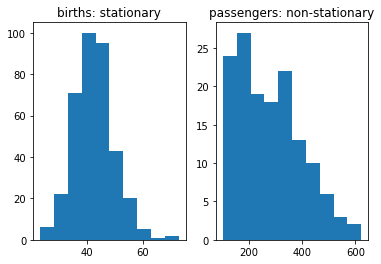

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(births)
ax1.set_title('births: stationary')
ax2.hist(passengers)
ax2.set_title('passengers: non-stationary');

 A log transform can be used to flatten out the exponential change back to a linear relationship.

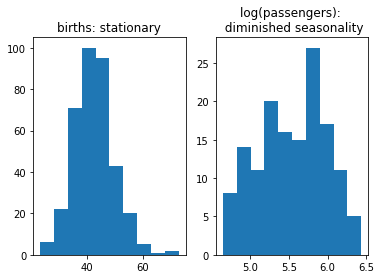

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(births)
ax1.set_title('births: stationary')
ax2.hist(np.log(passengers))
ax2.set_title('log(passengers): \n diminished seasonality');

#### 7.4 Statistical Tests: Augmented Dickery-Fuller (ADF)

- It's a type of statistical test called a unit root test.
- Unit root tests (also called random walk with drift) determine how strongly a time series is defined by a trend: if a time series has a unit root, it shows a systematic pattern that is unpredictable.

H0: the time series has a unit root = non-stationary<br>
H1: the time series does not have a unit root = stationary

p > 0.05 ==> failed to reject H0: time series is non-stationary<br>
p <= 0.05 ==> reject H0: time series is stationary<br>

ADF F% statistic > 0 ==> non-stationary<br>
ADF F% statistic < 0 ==> stationary

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
#from p value: births is stationary
adfuller_births = adfuller(births)

print('ADF Statistic: %f' % adfuller_births[0])
print('p-value: %f' % adfuller_births[1])
print('Critical Values:')
for key, value in adfuller_births[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.808291
p-value: 0.000052
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [19]:
#from p value: passengers is non-stationary
adfuller_passengers = adfuller(passengers)

print('ADF Statistic: %f' % adfuller_passengers[0])
print('p-value: %f' % adfuller_passengers[1])
print('Critical Values:')
for key, value in adfuller_passengers[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### <a id=8> 8. Model Evaluation </a>
#### 8.1 Multiple Train Test Splits

In [160]:
from sklearn.model_selection import TimeSeriesSplit

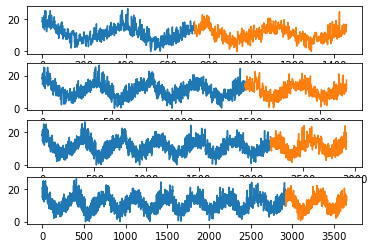

In [181]:
split = TimeSeriesSplit(n_splits=4)
X = temps.values

i = 1
for train_index, test_index in split.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    
    plt.subplot(410+i)
    plt.plot(X_train)
    plt.plot(np.array([None for x in X_train]+[x for x in X_test],dtype='object'))
    i +=1

#### 8.2 Walk Forward Validation (the k-folds validation of time series)

In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption.

1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
2. The model makes a prediction for the next time step.
3. The prediction is stored or evaluated against the known value.
4. The window is expanded to include the known value and the process is repeated (go to step 1.)

In [189]:
#No equivalent in sklearn so we use python
X = temps.values
n_train = 500

for i in range(n_train,len(X)):
    train = X[0:i]
    test = X[i:i+1]
    #we predict and evaluate within the loop
    print('train=%d, test=%d' % (len(train), len(test)))

train=500, test=1
train=501, test=1
train=502, test=1
train=503, test=1
train=504, test=1
train=505, test=1
train=506, test=1
train=507, test=1
train=508, test=1
train=509, test=1
train=510, test=1
train=511, test=1
train=512, test=1
train=513, test=1
train=514, test=1
train=515, test=1
train=516, test=1
train=517, test=1
train=518, test=1
train=519, test=1
train=520, test=1
train=521, test=1
train=522, test=1
train=523, test=1
train=524, test=1
train=525, test=1
train=526, test=1
train=527, test=1
train=528, test=1
train=529, test=1
train=530, test=1
train=531, test=1
train=532, test=1
train=533, test=1
train=534, test=1
train=535, test=1
train=536, test=1
train=537, test=1
train=538, test=1
train=539, test=1
train=540, test=1
train=541, test=1
train=542, test=1
train=543, test=1
train=544, test=1
train=545, test=1
train=546, test=1
train=547, test=1
train=548, test=1
train=549, test=1
train=550, test=1
train=551, test=1
train=552, test=1
train=553, test=1
train=554, test=1
train=555,

train=1559, test=1
train=1560, test=1
train=1561, test=1
train=1562, test=1
train=1563, test=1
train=1564, test=1
train=1565, test=1
train=1566, test=1
train=1567, test=1
train=1568, test=1
train=1569, test=1
train=1570, test=1
train=1571, test=1
train=1572, test=1
train=1573, test=1
train=1574, test=1
train=1575, test=1
train=1576, test=1
train=1577, test=1
train=1578, test=1
train=1579, test=1
train=1580, test=1
train=1581, test=1
train=1582, test=1
train=1583, test=1
train=1584, test=1
train=1585, test=1
train=1586, test=1
train=1587, test=1
train=1588, test=1
train=1589, test=1
train=1590, test=1
train=1591, test=1
train=1592, test=1
train=1593, test=1
train=1594, test=1
train=1595, test=1
train=1596, test=1
train=1597, test=1
train=1598, test=1
train=1599, test=1
train=1600, test=1
train=1601, test=1
train=1602, test=1
train=1603, test=1
train=1604, test=1
train=1605, test=1
train=1606, test=1
train=1607, test=1
train=1608, test=1
train=1609, test=1
train=1610, test=1
train=1611, 

train=2815, test=1
train=2816, test=1
train=2817, test=1
train=2818, test=1
train=2819, test=1
train=2820, test=1
train=2821, test=1
train=2822, test=1
train=2823, test=1
train=2824, test=1
train=2825, test=1
train=2826, test=1
train=2827, test=1
train=2828, test=1
train=2829, test=1
train=2830, test=1
train=2831, test=1
train=2832, test=1
train=2833, test=1
train=2834, test=1
train=2835, test=1
train=2836, test=1
train=2837, test=1
train=2838, test=1
train=2839, test=1
train=2840, test=1
train=2841, test=1
train=2842, test=1
train=2843, test=1
train=2844, test=1
train=2845, test=1
train=2846, test=1
train=2847, test=1
train=2848, test=1
train=2849, test=1
train=2850, test=1
train=2851, test=1
train=2852, test=1
train=2853, test=1
train=2854, test=1
train=2855, test=1
train=2856, test=1
train=2857, test=1
train=2858, test=1
train=2859, test=1
train=2860, test=1
train=2861, test=1
train=2862, test=1
train=2863, test=1
train=2864, test=1
train=2865, test=1
train=2866, test=1
train=2867, 

#### 8.3 Explorining Residual Errors

        residual_error = expected - forecast
    
When exploring residual errors we are looking for patterns or structure. A sign of a pattern suggests that the errors are not random. A sign of a pattern or structure suggests that there is more information that a model could capture and use to make better predictions

Basically we want residuals to be random noise. The methods we can use to check this are:
- Lineplots: are the values hovering over zero?
- Summary statistics: is the mean close to zero?
- Histograms/Density plots: is the distribution gaussian?
- Q-Q plots: is the distribution gaussian?
- Autocorrelation plots: are the values below the significance line?

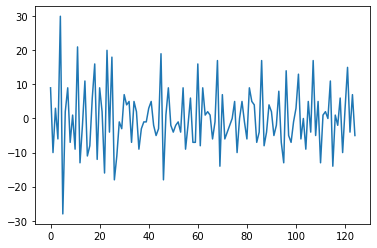

In [196]:
#Residual Lineplot: we expect it to be random around 0 and not show any trend or cyclic structure
X = pd.concat([births.shift(1),births],axis=1).values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = pd.DataFrame([test_y[i]-predictions[i] for i in range(len(predictions))])
# plot residuals
plt.plot(residuals);

In [197]:
#Residual summary statistics: espcially the mean, mean = 0 --> no bias in the forecast
residuals.describe()
#we get a value close to 0 but perhaps not close enough
#a naive method to improve the forecasts is ypred = ypred + mean

,0
count,125.000000
mean,0.064000
std,9.187776
min,-28.000000
25%,-6.000000
50%,-1.000000
75%,5.000000
max,30.000000


### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷

###  <a id=9> 9. Forecasting Models</a>

#### 9.1 Box-Jenkins Method

The Box-Jenkins is an iterative process that uses ARIMA for forecasting while following these steps:

1. Identification. Use the data and all related information to help select a sub-class of model that may best summarize the data.
    - step1: Check if the time series is stationary (unit root test), if not how many differences are required to make it stationary? (apply unit root test after each .diff() while avoiding over-differencing)
    
    - step2: Choose p & q parameters of the ARIMA model.   
    
        
2. Estimation: Use the data to train the parameters of the model (i.e. the coefficients).
3. Diagnostic Checking: Check for overfitting + Check that residual errors are white noise.



#### 9.2 Correcting Predictons with a Model of Residuals
If our residuals are not white noise. We can model them and add them as a correction to our prediction.
           
           improved_forecast = forecast + estimated_error

In [58]:
df = pd.concat([births.shift(1),births],axis=1)
df.columns = ['t','t+1']

train_index = int(0.66*len(df))
train = df.values[1:train_index]
test = df.values[train_index:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

#persistence model on training set
train_pred = X_train
#calculate the residuals
train_resid = y_train - train_pred

#model the residuals
model = AutoReg(train_resid)
model_fit = model.fit()
window = model_fit.ar_lags
coef = model_fit.params

#too boring to continue

### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### Moving Average Smoothing
The purpose of smoothing is to remove noise and better expose the signal of the underlying causal processes. There are 2 types:
- Centered:  C(t) = mean(obs(t-1),obs(t),obs(t+1))
- Trailing: T(t) = mean(obs(t-2),obs(t-1),obs(t))

Calculating a moving average of a time series assumes that both trend and seasonal components have been removed from the time series --> stationary, or does not show obvious trends (long-term increasing or decreasing movement) or seasonality (consistent periodic structure)

In [190]:
births.head(2)

,Births
Date,
1959-01-01,35
1959-01-02,32


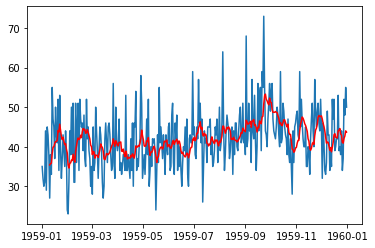

In [8]:
rolling_births = births.rolling(10).mean()

fig, ax = plt.subplots()
ax.plot(births)
ax.plot(rolling_births,color='r');

<AxesSubplot:xlabel='Month'>

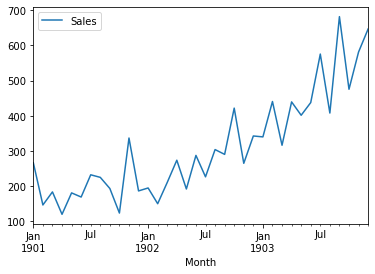

In [4]:
shampoo.plot()

In [5]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

<ipython-input-5-654683e0c124>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [6]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

In [8]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [12]:
difference(shampoo,interval=1)

KeyError: 1